In [1]:
%load_ext autoreload
%autoreload 2
# %config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json
import matplotlib as mpl

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from surp import ViceModel, yields, subgiants
from surp import gce_math as gcem

import surp
import arya

In [4]:
from singlezone import run_singlezone

In [5]:
subgiants_ha = subgiants[subgiants.high_alpha]

all_abundances = pd.read_csv("data_analysis/all_data.csv")

fiducial = ViceModel.from_saved("../models/C11_f0.2/model.json")

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

In [17]:
yp = surp.YieldParams.from_file("../models/C11_f0.2/yield_params.json")
surp.set_yields(yp)

sz_fiducial = run_singlezone(eta=1, t_end=10, tau_star=2, tau_sfh=10)[1]

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [21]:
yp.c_cc_model = "BiLin"
surp.set_yields(yp)


sz_models = [
    run_singlezone(eta=0, t_end=13, tau_star=2, tau_sfh=5)[1],
    run_singlezone(eta=1, t_end=10, tau_star=2, tau_sfh=10)[1],
    run_singlezone(eta=9, t_end=3, tau_star=5, tau_sfh=3)[1],
    # sz_model(eta=15, t_end=5, tau_sfh=1)
]

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)
/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: Use

In [22]:
MoverH = np.linspace(-5, 0.5)
Z = gcem.MH_to_Z(MoverH)

y_total = gcem.calc_y(Z)
y_agb = gcem.calc_y(Z, kind="agb")
y_cc = gcem.calc_y(Z, kind="cc")
y_ia = gcem.calc_y(Z, kind="ia")

yo = gcem.calc_y(ele="o")

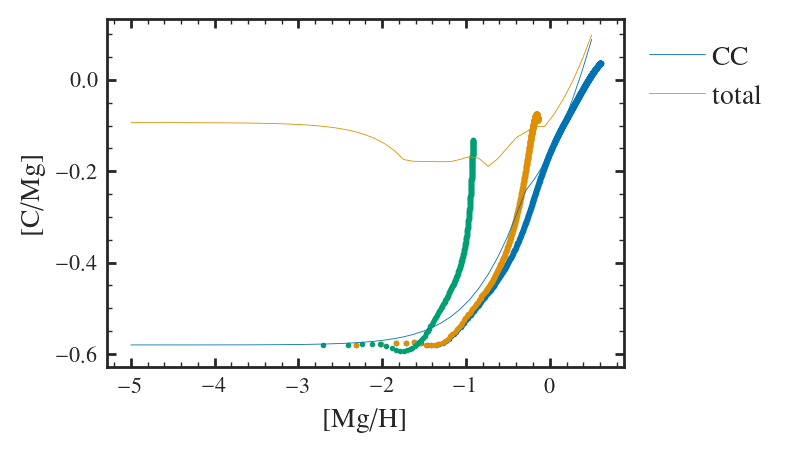

In [23]:
for h in sz_models:
    plt.scatter(h.O_H, h.C_O, s=1)

plt.plot(MoverH, gcem.abund_to_brak(y_cc/yo, "c", "o"), lw=0.3, label="CC")
plt.plot(MoverH, gcem.abund_to_brak(y_total/yo, "c", "o"), lw=0.3, label="total")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

arya.Legend(-1)

In [32]:
from arya import COLORS

In [39]:
legend_key = {
    "RL": dict(label="HII regions", marker="o", color=COLORS[1]),
    "dwarf": dict(label="dwarf galaxies", marker="d", color=COLORS[3]),
    "star": dict(label="halo/thick disk stars", marker="*", color=COLORS[0]),
    "DLA": dict(label="dampled Lyman-$\\alpha$", marker="^", color=COLORS[6]),

}

legend_labels = {
    "RL": "HII regions"
}


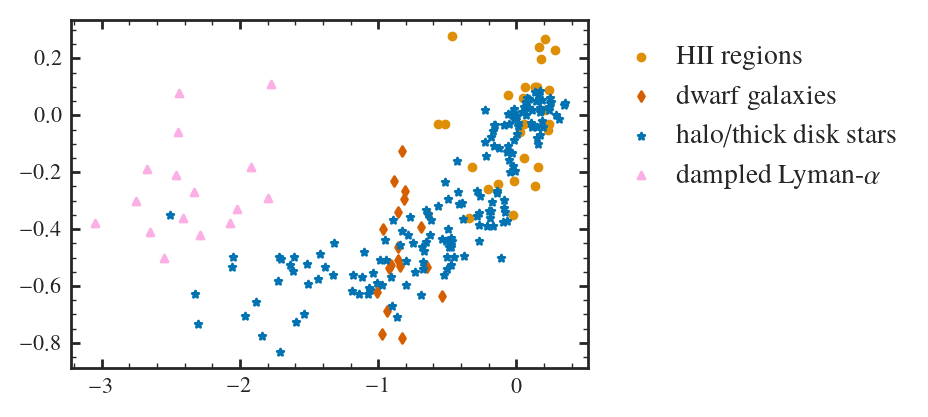

In [38]:
def plot_all():
    for key in ["RL", "dwarf", "star", "DLA"]:
        df = all_abundances[all_abundances.type == key]
        plt.scatter(df["[o/h]"], df["[c/o]"], **legend_key[key])
        
plot_all()
arya.Legend(-1)


In [ ]:
def plot_errorbars():
    df = all_abundances[all_abundances.type == "star"]
    x_err = np.mean(df["[o/h]_err"])
    y_err = np.mean(df["[c/o]_err"])
    plt.errorbar()
    e_idx = np.intersect1d(df.index, [68, 36, 2, 82, 239])
    if len(e_idx) == 1:

        plt.errorbar(df["[o/h]"][e_idx], df["[c/o]"][e_idx], xerr=x_err, yerr=y_err, 
                     markersize=0, color=color, capsize=0)

In [73]:
df[idx_h].index

Index([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
       ...
       217, 218, 219, 220, 221, 222, 241, 243, 245, 246],
      dtype='int64', length=152)

In [59]:
df.loc[i]["[o/h]"]

-1.3263

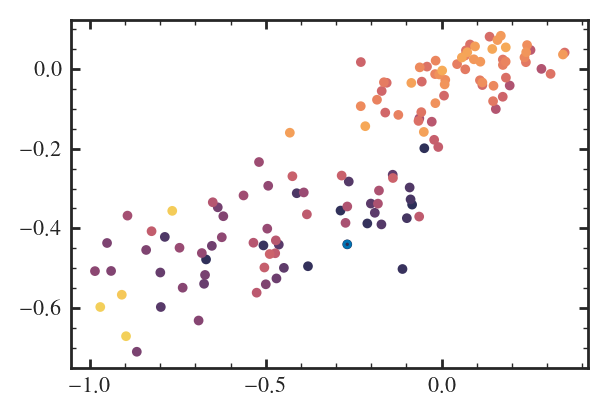

In [78]:
plt.scatter(df[idx_h]["[o/h]"], df[idx_h]["[c/o]"], c=df[idx_h].index)
i = 72
plt.scatter(df.loc[i]["[o/h]"], df.loc[i]["[c/o]"], s=5, fc="None", ec=COLORS[0])

-1.7141 -0.8314999999999999 0.033779411764705884 0.07255294117647057
-0.2682 -0.4403 0.01741259259259259 0.039125757575757564


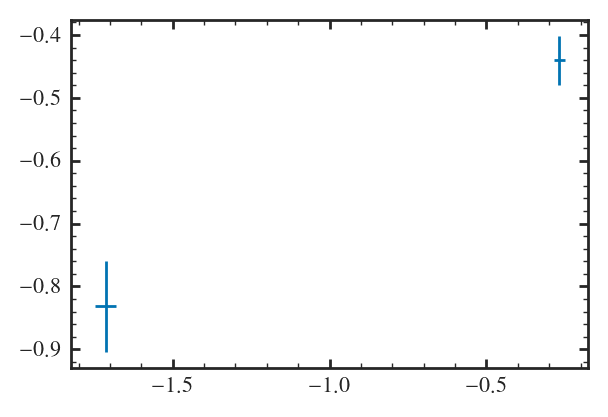

In [79]:
#plot errorbars on stars
cut_mh = -1
df = all_abundances[all_abundances.type == "star"]
idx_l = df["[o/h]"] < cut_mh
idx_h = ~idx_l
for j, idx in enumerate([idx_l, idx_h]):
    i = [257, 72][j]
    df_c = df.loc[idx]
    x = df_c["[o/h]"][i]
    y = df_c["[c/o]"][i]
    xerr = np.nanmean(df_c["[o/h]_err"])
    yerr = np.nanmean(df_c["[c/o]_err"])
    color=arya.style.COLORS[0]
    print(x, y, xerr, yerr)

    plt.errorbar(x, y, xerr=xerr, yerr=yerr, ms=0, capsize=0, color=color)

[ 82 239]
-1.3215 -0.4494 0.024659420289855072 0.06584999999999998
nan nan 0.017977 0.03285299999999999


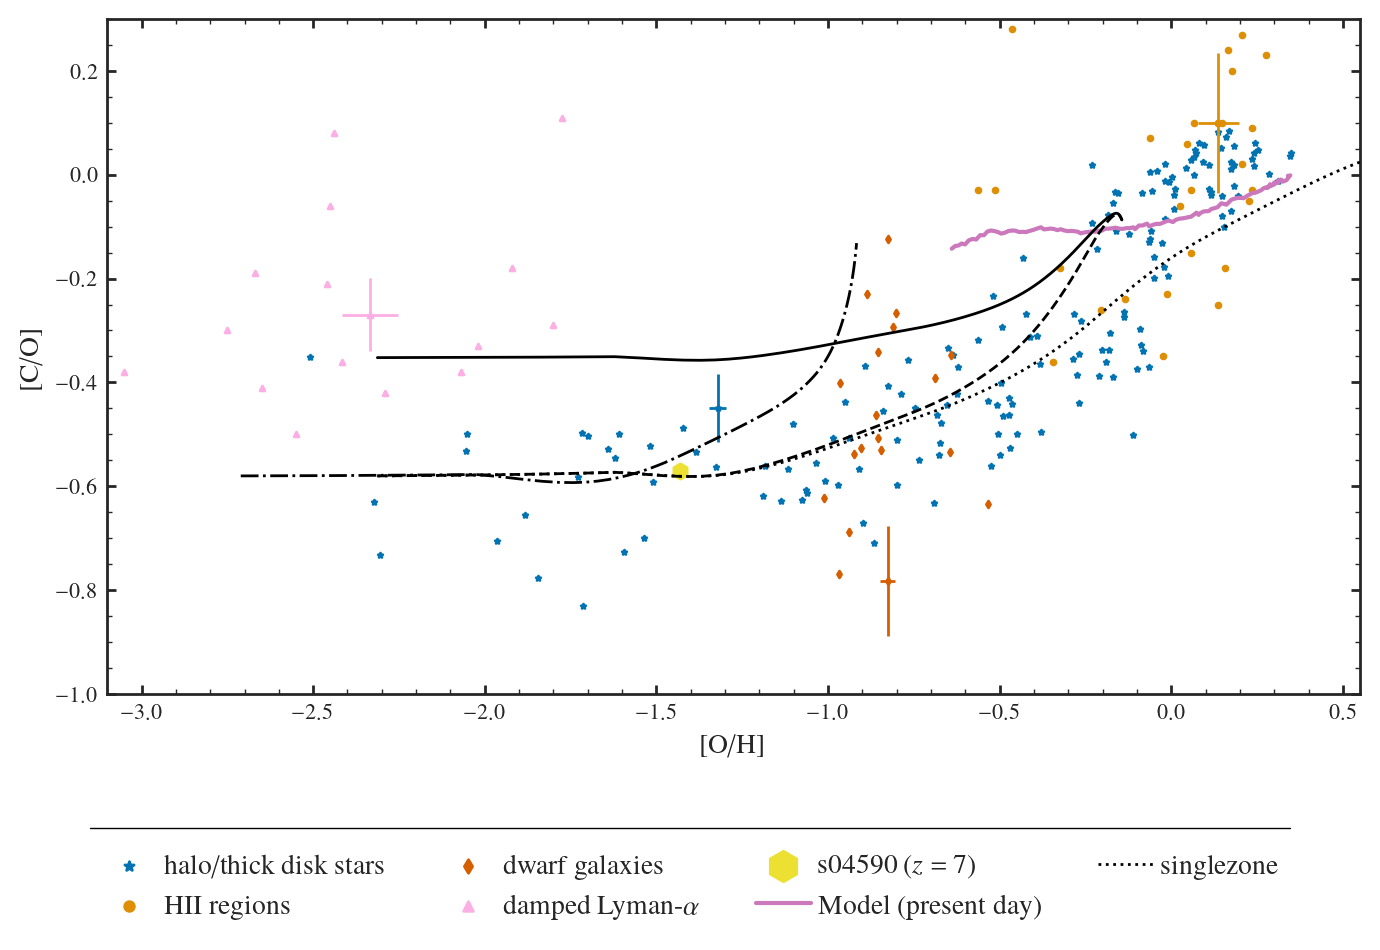

In [29]:
fig = plt.figure(figsize=(7, 4))
    

    

plt.plot()

plt.ylim(-1, 0.3)
plt.xlim(-3.1, 0.55)

lab = plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")

s04590_x = gcem.eps_to_brak(7.12, "o")
s_y = gcem.log_to_brak(-0.83, "c", "o")
plt.scatter([-1.43], [-0.57], marker="h", s=30, label="s04590 ($z=7$)", color=arya.style.COLORS[8])


surp.plots.plot_annulus_at_t(fiducial, "O_H", "C_O", label="Model (present day)", zorder=3, lw=1.5, color=arya.style.COLORS[4])

# fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model ($t=2$ Gyr)", zorder=3, lw=2, color=arya.style.COLORS[4])

for i in range(len(sz_models)):
    out = sz_models[i]
    if i == 0:
        label="singlezone"
    else:
        label=""
    plt.plot(out.O_H, out.C_O, label=label, color="k", 
             lw=1, zorder=4, ls=[":", "--", "-."][i])

plt.plot(sz_fiducial.O_H, sz_fiducial.C_O, label=label, color="k", 
         lw=1, zorder=4)

    

leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4, markerscale=2)
box1 = leg.get_tightbbox()
box2 = lab.get_tightbbox() 


t1 = box1.transformed(fig.transFigure.inverted())
t2 = box2.transformed(fig.transFigure.inverted())
ym = (t2.y0 + t1.y1)/2


fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))


plt.xlabel(r"[O/H]")
plt.ylabel(r"[C/O]")
plt.tight_layout()

plt.savefig("figures/summary.pdf")